In [1]:
%load_ext rpy2.ipython
%R library(dplyr); library(magrittr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<StrVector - Python:0x10a502758 / R:0x106f2a2b0>
[str, str, str, ..., str, str, str]

In [7]:
pwd

u'/Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/codetesting'

In [8]:
from pyfaidx import Fasta
import os.path
import os

#os.chdir("./codetesting/")

prelim_groups=open("../phage_by_group.txt").readlines()

next_step=[]

for i in range(0,len(prelim_groups),10):
    line=prelim_groups[i].rstrip("\n")
    vec=line.split("\t")
    next_step.append(vec[0])


grouplist=next_step
print(len(grouplist))


29


In [42]:
%%R
#All Coverage Checking Functions:

cos_check<-function(item, filename, cos_sd_factor=4){
        coverage<-read.table(filename, sep="\t")
        length<-nrow(coverage)
        cos_omit_ends_cov<-coverage[(200:(length-200)),]   #excluding larger ends of the contig in this case      
        cos_below_ave<-cos_omit_ends_cov[cos_omit_ends_cov$V3<(mean(coverage$V3)-(sd(coverage$V3)*cos_sd_factor)),]
        minlocation<-0    
        if (nrow(cos_below_ave)>0){
            
            cos_below_ave$gaps<-c(diff(cos_below_ave$V2),1)
            cos_below_ave_peaks<-cos_below_ave[cos_below_ave$gaps<5,]
            size<-max(cos_below_ave_peaks$V2)-min(cos_below_ave_peaks$V2)
            if (size < 1000 & size>50){
                
                return(TRUE)

        } else {return(FALSE)}
        } else {return(FALSE)}
            }

mu_check<-function(item, filename, mu_factor=5){
         coverage<-read.table(filename, sep="\t")
         length=nrow(coverage)
         peaks<-coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*mu_factor),]
         mu_size<-max(peaks$V2)-min(peaks$V2) 

                
        if (((min(peaks$V2)<500&max(peaks$V2)<500)|(min(peaks$V2)>(length-500)&max(peaks$V2)>length-500)) & mu_size<300 & (coverage$V2[coverage$V3==min(coverage$V3)]<500|coverage$V2[coverage$V3==min(coverage$V3)]>(length-500))){
           return(TRUE)
            }
        else {return(FALSE)}
        }

sip_check<-function(item, filename, stretch=6, sd_factor=1){
    
    coverage<-read.table(filename, sep="\t")
    length<-nrow(coverage)
    coverage$V3_stretch<-coverage$V3^stretch
    coverage1<-coverage[(500:(length-500)),] 
    above_ave<-coverage1[coverage1$V3_stretch>(mean(coverage$V3_stretch)+sd(coverage$V3_stretch)*sd_factor),]
    above_ave$gaps<-c(diff(above_ave$V2),1)
    aa_region_mean<-mean(coverage[min(above_ave$V2):max(above_ave$V2),]$V3)
    all_mean<-mean(coverage$V3)
        
    size<-max(above_ave$V2)-min(above_ave$V2)

    #print(paste(item, paste(aamin, aamax, sep=" to "),"region coverage is", aa_region, "; total coverage is", all_mean,sep=" "))
    if(nrow(above_ave)>1 & (aa_region_mean>(all_mean+(sd(coverage$V3)*sd_factor))) & length>15000){
        if (size<1000){
            return(TRUE)
            }
        else {return(FALSE)}
    }  else {return(FALSE)}
    }

mp_check<-function(item, filename, stretch=5, mp_sd_factor=5){
        coverage<-read.table(filename, sep="\t")
        length<-nrow(coverage)

        coverage$V3_stretch<-coverage$V3^stretch        

        mp_omit_ends_cov<-coverage[(200:(length-200)),]   #excluding larger ends of the contig in this case
        mp_above_ave<-mp_omit_ends_cov[mp_omit_ends_cov$V3>(mean(coverage$V3)+sd(coverage$V3)*mp_sd_factor),]
    if (nrow(mp_above_ave)>0){
        
        mp_above_ave$gaps<-c(diff(mp_above_ave$V2),1)
        mp_above_ave_peaks<-mp_above_ave[mp_above_ave$gaps>2000,] 
        
        if (nrow(mp_above_ave_peaks)>0){
                return(TRUE)
   
        
        }else {return(FALSE)}}
    else {
            return(FALSE)}
    }

cov_shift_test<-function(item, filename, mean_threshold=6, split_cat="a"){
    if(split_cat=="a"){splits=c(1200,1300,1400,1500,1600,1800,2000)}
    if(split_cat=="b"){splits=c(800,1000,1200,1300,1400,1500,1600,1800,2000)}
    
    
    coverage<-read.table(filename, sep="\t")
    length<-nrow(coverage)
    shift="no"
    if(length>max(splits)){ 
        for (s in splits){
        
        coverage$bins<-as.numeric(cut(coverage$V2, round(length/s)))
        bin_sum<-group_by(coverage, bins)%>%summarise(mean=mean(V3), stdev=sd(V3)) 
        bin_sum$dif<-c(abs(diff(bin_sum$mean)),0)
        threshold<-mean(bin_sum$dif)*mean_threshold
        if ((max(bin_sum$dif)>threshold) & (nrow(bin_sum[bin_sum$dif>threshold,])==1)){
            shift="yes"
            break
        } else {next}
        }
    if (shift=="yes"){
        return(TRUE)
    } else {return(FALSE)}
     
    }else{return(FALSE)}}

even_check<-function(item, filename, upper_sd_factor=5, pts_above_thresh=10){
        coverage<-read.table(filename, sep="\t")
        even_above_ave<-coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*upper_sd_factor),]
        
        if (nrow(even_above_ave)<pts_above_thresh)  {
            
            return(TRUE)
            
        } else {return(FALSE)}
        }


In [ ]:
%%R
### to check for a cos dip:

cos_check<-function(item, filename, cos_sd_factor=4){
        coverage<-read.table(filename, sep="\t")
        length<-nrow(coverage)
        cos_omit_ends_cov<-coverage[(200:(length-200)),]   #excluding larger ends of the contig in this case      
        cos_below_ave<-cos_omit_ends_cov[cos_omit_ends_cov$V3<(mean(coverage$V3)-(sd(coverage$V3)*cos_sd_factor)),]
        minlocation<-0    
        if (nrow(cos_below_ave)>0){
            
            cos_below_ave$gaps<-c(diff(cos_below_ave$V2),1)
            cos_below_ave_peaks<-cos_below_ave[cos_below_ave$gaps<5,]
            size<-max(cos_below_ave_peaks$V2)-min(cos_below_ave_peaks$V2)
            if (size < 1000 & size>50){
                
                return(TRUE)

        } else {return(FALSE)}
        } else {return(FALSE)}
            }

[1] "1.003.O."
[1] "no cos pattern"
[1] "1.016.O."
[1] "no cos pattern"
[1] "1.026.O."
[1] "no cos pattern"
[1] "1.036.O."
[1] "no cos pattern"
[1] "1.048.O."
[1] "no cos pattern"
[1] "1.062.O."
[1] "no cos pattern"
[1] "1.074.O."
[1] "no cos pattern"
[1] "1.085.O."
[1] "no cos pattern"
[1] "1.097.O."
[1] "no cos pattern"
[1] "1.107.B."
[1] "no cos pattern"
[1] "1.116.O."
[1] "no cos pattern"
[1] "1.125.O."
[1] "no cos pattern"
[1] "1.138.O."
[1] "no cos pattern"
[1] "1.150.O."
[1] "no cos pattern"
[1] "1.161.O."
[1] "no cos pattern"
[1] "1.172.O."
[1] "no cos pattern"
[1] "1.183.O."
[1] "no cos pattern"
[1] "1.189.O."
[1] "no cos pattern"
[1] "1.199.A."
[1] "no cos pattern"
[1] "1.209.O."
[1] "1.209.O. has a cos pattern"
[1] "1.217.O."
[1] "no cos pattern"
[1] "1.233.A."
[1] "no cos pattern"
[1] "1.242.O."
[1] "no cos pattern"
[1] "1.250.O."
[1] "no cos pattern"
[1] "1.263.A."
[1] "no cos pattern"
[1] "1.270.B."
[1] "no cos pattern"
[1] "1.278.O."
[1] "no cos pattern"
[1] "1.287.O."
[

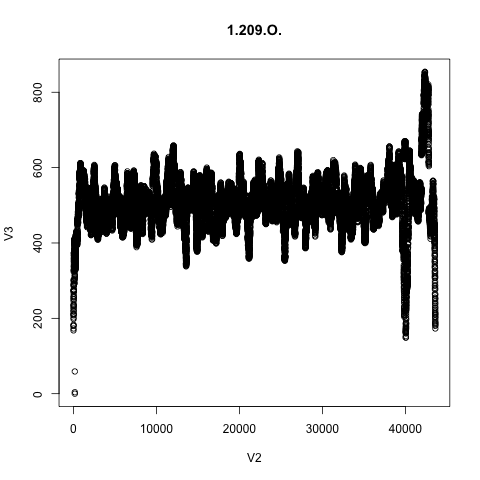

In [51]:
%%R -i grouplist
for (item in grouplist){
    filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
    print(item)
    if(file.info(filename)$size>0) {
    if (cos_check(item, filename)){
        print(paste(item, "has a cos pattern", sep=" "))
        coverage<-read.table(filename, sep="\t")
        with(coverage, plot(V2, V3, main=item))
    } else{
        print("no cos pattern")
    }
    }}

In [49]:
%%R
#Check for mu-like pattern of a maximum peak near the end, a minima at the end, and potentially a small region of very low coverage at an end
mu_check<-function(item, filename, mu_factor=5){
         coverage<-read.table(filename, sep="\t")
         length=nrow(coverage)
         peaks<-coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*mu_factor),]
         mu_size<-max(peaks$V2)-min(peaks$V2) 

                
        if (((min(peaks$V2)<500&max(peaks$V2)<500)|(min(peaks$V2)>(length-500)&max(peaks$V2)>length-500)) & mu_size<300 & (coverage$V2[coverage$V3==min(coverage$V3)]<500|coverage$V2[coverage$V3==min(coverage$V3)]>(length-500))){
           return(TRUE)
            }
        else {return(FALSE)}
        }

In [47]:
%%R
item="1.156.O."
filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
mu_check(item, filename)

[1] TRUE


[1] "1.003.O."
[1] "no mu pattern"
[1] "1.016.O."
[1] "no mu pattern"
[1] "1.026.O."
[1] "no mu pattern"
[1] "1.036.O."
[1] "no mu pattern"
[1] "1.048.O."
[1] "no mu pattern"
[1] "1.062.O."
[1] "no mu pattern"
[1] "1.074.O."
[1] "no mu pattern"
[1] "1.085.O."
[1] "no mu pattern"
[1] "1.097.O."
[1] "no mu pattern"
[1] "1.107.B."
[1] "no mu pattern"
[1] "1.116.O."
[1] "no mu pattern"
[1] "1.125.O."
[1] "no mu pattern"
[1] "1.138.O."
[1] "no mu pattern"
[1] "1.150.O."
[1] "no mu pattern"
[1] "1.161.O."
[1] "no mu pattern"
[1] "1.172.O."
[1] "no mu pattern"
[1] "1.183.O."
[1] "no mu pattern"
[1] "1.189.O."
[1] "no mu pattern"
[1] "1.199.A."
[1] "no mu pattern"
[1] "1.209.O."
[1] "no mu pattern"
[1] "1.217.O."
[1] "1.217.O. has a mu pattern"
[1] "1.233.A."
[1] "no mu pattern"
[1] "1.242.O."
[1] "no mu pattern"
[1] "1.250.O."
[1] "no mu pattern"
[1] "1.263.A."
[1] "no mu pattern"
[1] "1.270.B."
[1] "no mu pattern"
[1] "1.278.O."
[1] "no mu pattern"
[1] "1.287.O."
[1] "no mu pattern"
[1] "2.0

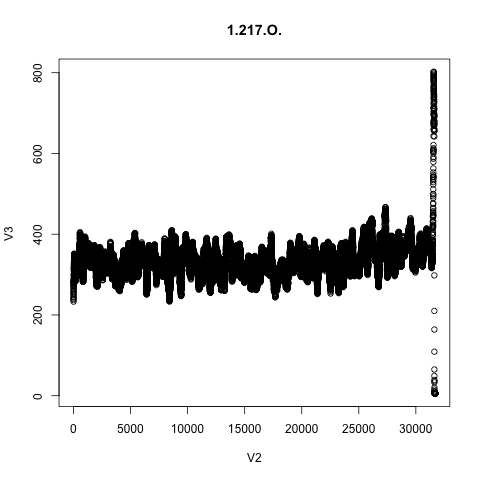

In [52]:
%%R -i grouplist
for (item in grouplist){
    filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
    print(item)
    if(file.info(filename)$size>0) {
    if (mu_check(item, filename)){
        print(paste(item, "has a mu pattern", sep=" "))
        coverage<-read.table(filename, sep="\t")
        with(coverage, plot(V2, V3, main=item))
    } else{
        print("no mu pattern")
    }
    }}

In [59]:
%%R

sip_check<-function(item, filename, stretch=6, sd_factor=1){
    
    coverage<-read.table(filename, sep="\t")
    length<-nrow(coverage)
    coverage$V3_stretch<-coverage$V3^stretch
    coverage1<-coverage[(500:(length-500)),] 
    above_ave<-coverage1[coverage1$V3_stretch>(mean(coverage$V3_stretch)+sd(coverage$V3_stretch)*sd_factor),]
    above_ave$gaps<-c(diff(above_ave$V2),1)
    aa_region_mean<-mean(coverage[min(above_ave$V2):max(above_ave$V2),]$V3)
    all_mean<-mean(coverage$V3)
        
    size<-max(above_ave$V2)-min(above_ave$V2)

    #print(paste(item, paste(aamin, aamax, sep=" to "),"region coverage is", aa_region, "; total coverage is", all_mean,sep=" "))
    if(nrow(above_ave)>1 & (aa_region_mean>(all_mean+(sd(coverage$V3)*sd_factor))) & length>15000){
        if (size<1000){
            return(TRUE)
            }
        else {return(FALSE)}
    }  else {return(FALSE)}
    }

In [60]:
%%R
item="1.188.A."
filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
sip_check(item, filename)

[1] TRUE


[1] "1.003.O."
[1] "no sip pattern"
[1] "1.016.O."
[1] "no sip pattern"
[1] "1.026.O."
[1] "1.026.O. has a sip pattern"
[1] "1.036.O."
[1] "no sip pattern"
[1] "1.048.O."
[1] "no sip pattern"
[1] "1.062.O."
[1] "no sip pattern"
[1] "1.074.O."
[1] "no sip pattern"
[1] "1.085.O."
[1] "no sip pattern"
[1] "1.097.O."
[1] "no sip pattern"
[1] "1.107.B."
[1] "no sip pattern"
[1] "1.116.O."
[1] "no sip pattern"
[1] "1.125.O."
[1] "no sip pattern"
[1] "1.138.O."
[1] "1.138.O. has a sip pattern"
[1] "1.150.O."
[1] "1.150.O. has a sip pattern"
[1] "1.161.O."
[1] "no sip pattern"
[1] "1.172.O."
[1] "no sip pattern"
[1] "1.183.O."
[1] "1.183.O. has a sip pattern"
[1] "1.189.O."
[1] "no sip pattern"
[1] "1.199.A."
[1] "no sip pattern"
[1] "1.209.O."
[1] "no sip pattern"
[1] "1.217.O."
[1] "1.217.O. has a sip pattern"
[1] "1.233.A."
[1] "no sip pattern"
[1] "1.242.O."
[1] "no sip pattern"
[1] "1.250.O."
[1] "no sip pattern"
[1] "1.263.A."
[1] "no sip pattern"
[1] "1.270.B."
[1] "no sip pattern"
[1] 

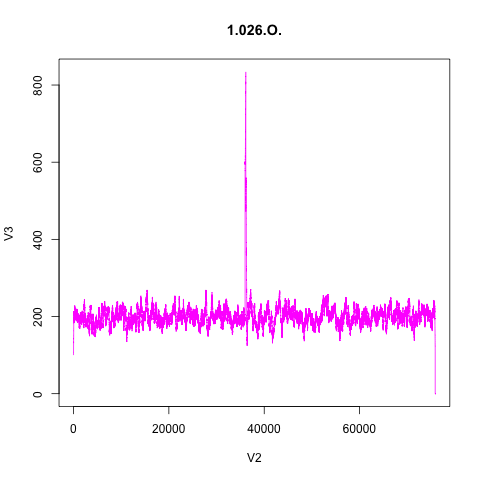

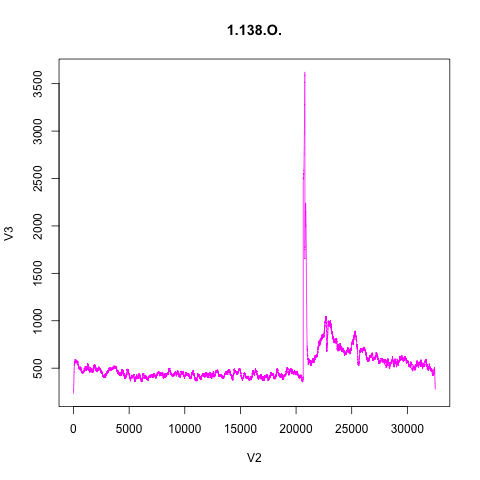

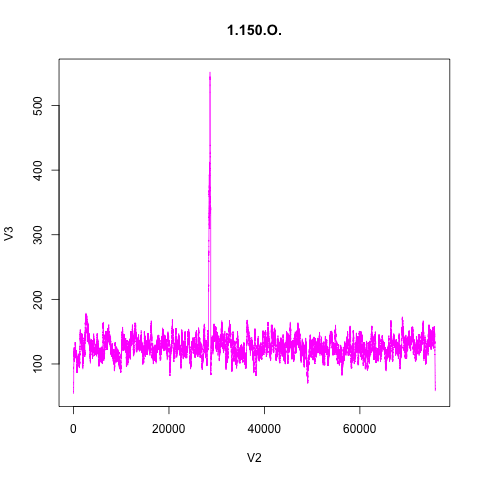

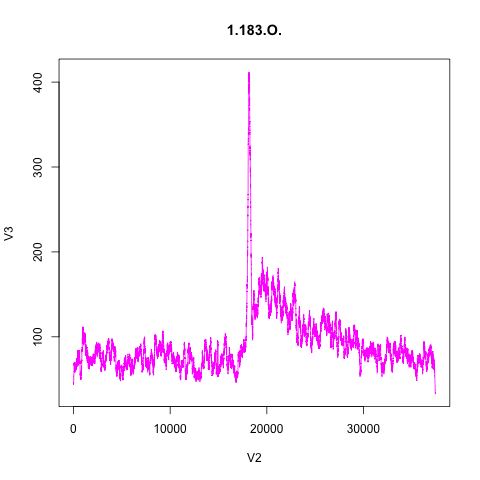

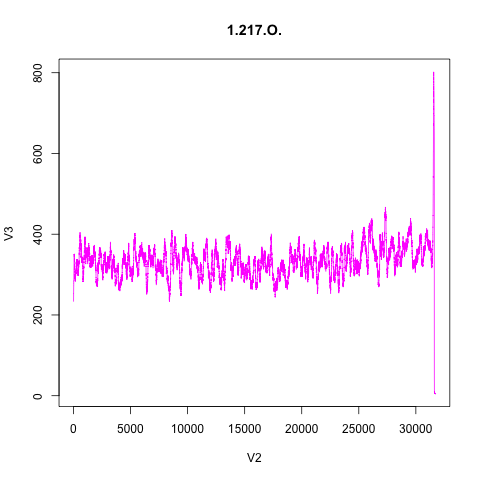

In [61]:
%%R -i grouplist
for (item in grouplist){
    filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
    print(item)
    if(file.info(filename)$size>0) {
    if (sip_check(item, filename)){
        print(paste(item, "has a sip pattern", sep=" "))
        coverage<-read.table(filename, sep="\t")
        with(coverage, plot(V2, V3, main=item, type="l", col="magenta"))
    } else{
        print("no sip pattern")
    }
    }}

In [64]:
%%R
###Test to see if coverage profile has multiple peaks:

mp_check<-function(item, filename, stretch=5, mp_sd_factor=5){
        coverage<-read.table(filename, sep="\t")
        length<-nrow(coverage)

        coverage$V3_stretch<-coverage$V3^stretch        

        mp_omit_ends_cov<-coverage[(200:(length-200)),]   #excluding larger ends of the contig in this case
        mp_above_ave<-mp_omit_ends_cov[mp_omit_ends_cov$V3>(mean(coverage$V3)+sd(coverage$V3)*mp_sd_factor),]
    if (nrow(mp_above_ave)>0){
        
        mp_above_ave$gaps<-c(diff(mp_above_ave$V2),1)
        mp_above_ave_peaks<-mp_above_ave[mp_above_ave$gaps>2000,] 
        
        if (nrow(mp_above_ave_peaks)>0){
                return(TRUE)
   
        
        }else {return(FALSE)}}
    else {
            return(FALSE)}
    }

In [65]:
%%R
item="1.007.O."
filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
mp_check(item, filename)

[1] TRUE


[1] "1.003.O."
[1] "no multiple peaks"
[1] "1.016.O."
[1] "1.016.O. has a multiple peaks"
[1] "1.026.O."
[1] "no multiple peaks"
[1] "1.036.O."
[1] "no multiple peaks"
[1] "1.048.O."
[1] "no multiple peaks"
[1] "1.062.O."
[1] "no multiple peaks"
[1] "1.074.O."
[1] "no multiple peaks"
[1] "1.085.O."
[1] "no multiple peaks"
[1] "1.097.O."
[1] "no multiple peaks"
[1] "1.107.B."
[1] "no multiple peaks"
[1] "1.116.O."
[1] "no multiple peaks"
[1] "1.125.O."
[1] "no multiple peaks"
[1] "1.138.O."
[1] "no multiple peaks"
[1] "1.150.O."
[1] "no multiple peaks"
[1] "1.161.O."
[1] "no multiple peaks"
[1] "1.172.O."
[1] "no multiple peaks"
[1] "1.183.O."
[1] "no multiple peaks"
[1] "1.189.O."
[1] "no multiple peaks"
[1] "1.199.A."
[1] "no multiple peaks"
[1] "1.209.O."
[1] "no multiple peaks"
[1] "1.217.O."
[1] "no multiple peaks"
[1] "1.233.A."
[1] "no multiple peaks"
[1] "1.242.O."
[1] "no multiple peaks"
[1] "1.250.O."
[1] "no multiple peaks"
[1] "1.263.A."
[1] "no multiple peaks"
[1] "1.270.B.

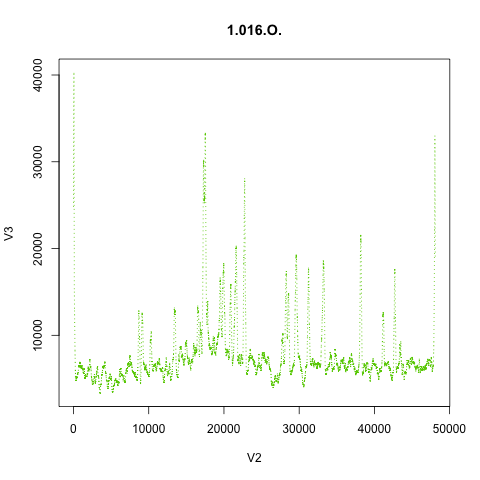

In [68]:
%%R -i grouplist
for (item in grouplist){
    filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
    print(item)
    if(file.info(filename)$size>0) {
    if (mp_check(item, filename)){
        print(paste(item, "has a multiple peaks", sep=" "))
        coverage<-read.table(filename, sep="\t")
        with(coverage, plot(V2, V3, main=item, type="l", col="chartreuse3", lty=3))
    } else{
        print("no multiple peaks")
    }
    }}

In [82]:
%%R

###Identifies shifts in coverage.  Consequently also tends to identify small internal peaks in coverage.

cov_shift_test<-function(item, filename, mean_threshold=6, split_cat="a"){
    if(split_cat=="a"){splits=c(1200,1300,1400,1500,1600,1800,2000)}
    if(split_cat=="b"){splits=c(800,1000,1200,1300,1400,1500,1600,1800,2000)}
    
    
    coverage<-read.table(filename, sep="\t")
    length<-nrow(coverage)
    shift="no"
    if(length>max(splits)){ 
        for (s in splits){
        
        coverage$bins<-as.numeric(cut(coverage$V2, round(length/s)))
        bin_sum<-group_by(coverage, bins)%>%summarise(mean=mean(V3), stdev=sd(V3)) 
        bin_sum$dif<-c(abs(diff(bin_sum$mean)),0)
        threshold<-mean(bin_sum$dif)*mean_threshold
        if ((max(bin_sum$dif)>threshold) & (nrow(bin_sum[bin_sum$dif>threshold,])==1)){
            shift="yes"
            break
        } else {next}
        }
    if (shift=="yes"){
        return(TRUE)
    } else {return(FALSE)}
     
    }else{return(FALSE)}}

In [83]:
%%R
item="1.027.O."
filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
cov_shift_test(item, filename, split_cat="b")

[1] TRUE


[1] "1.003.O."
[1] "no coverage shift"
[1] "1.016.O."
[1] "no coverage shift"
[1] "1.026.O."
[1] "1.026.O. has a coverage shift"
[1] "1.036.O."
[1] "no coverage shift"
[1] "1.048.O."
[1] "no coverage shift"
[1] "1.062.O."
[1] "no coverage shift"
[1] "1.074.O."
[1] "no coverage shift"
[1] "1.085.O."
[1] "no coverage shift"
[1] "1.097.O."
[1] "no coverage shift"
[1] "1.107.B."
[1] "no coverage shift"
[1] "1.116.O."
[1] "no coverage shift"
[1] "1.125.O."
[1] "no coverage shift"
[1] "1.138.O."
[1] "1.138.O. has a coverage shift"
[1] "1.150.O."
[1] "1.150.O. has a coverage shift"
[1] "1.161.O."
[1] "no coverage shift"
[1] "1.172.O."
[1] "no coverage shift"
[1] "1.183.O."
[1] "1.183.O. has a coverage shift"
[1] "1.189.O."
[1] "no coverage shift"
[1] "1.199.A."
[1] "no coverage shift"
[1] "1.209.O."
[1] "no coverage shift"
[1] "1.217.O."
[1] "no coverage shift"
[1] "1.233.A."
[1] "1.233.A. has a coverage shift"
[1] "1.242.O."
[1] "1.242.O. has a coverage shift"
[1] "1.250.O."
[1] "no coverage

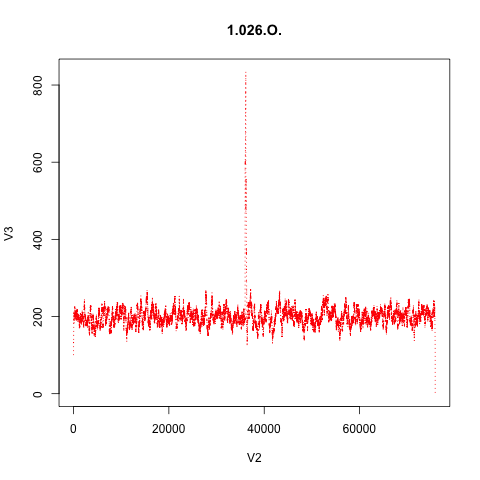

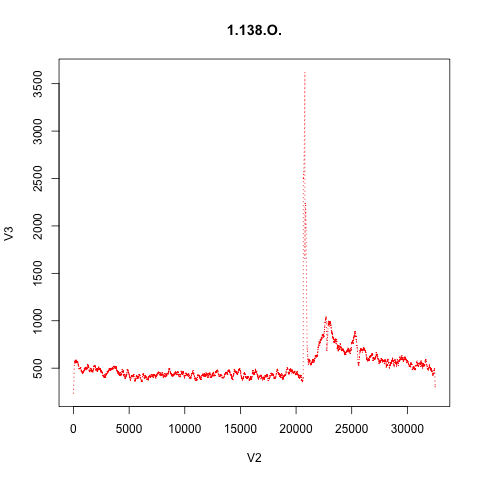

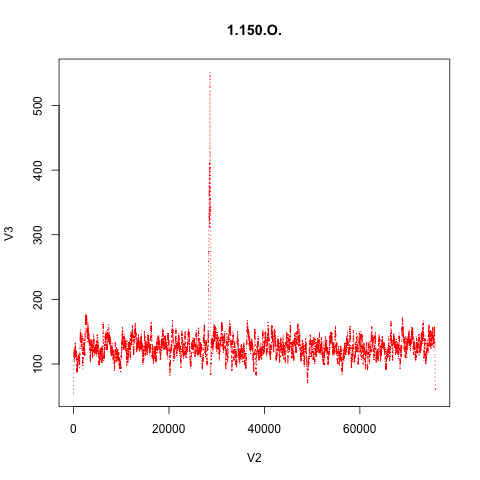

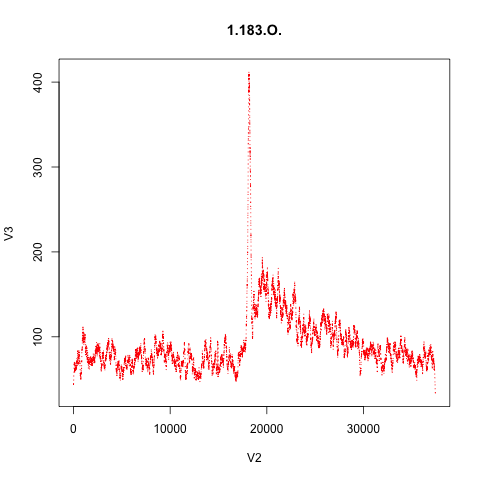

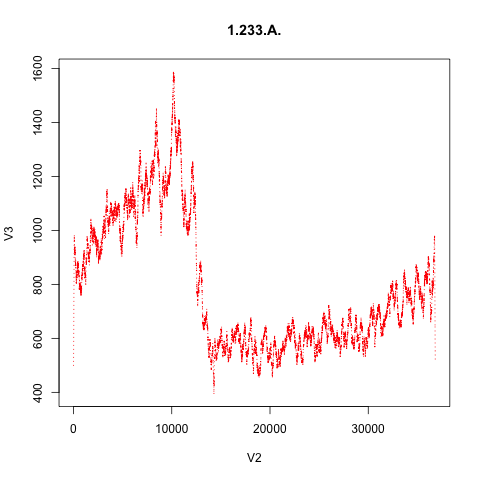

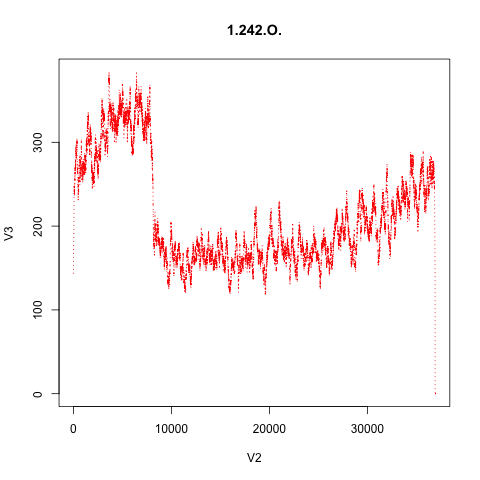

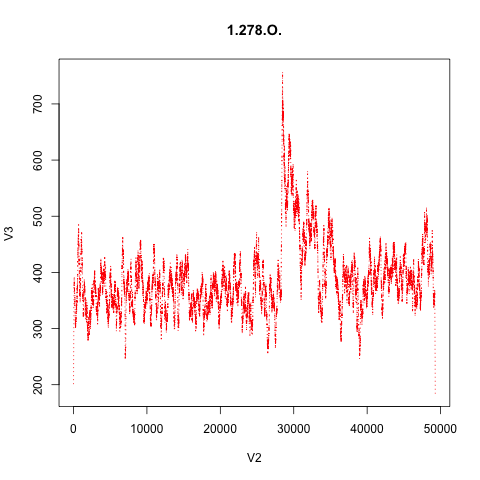

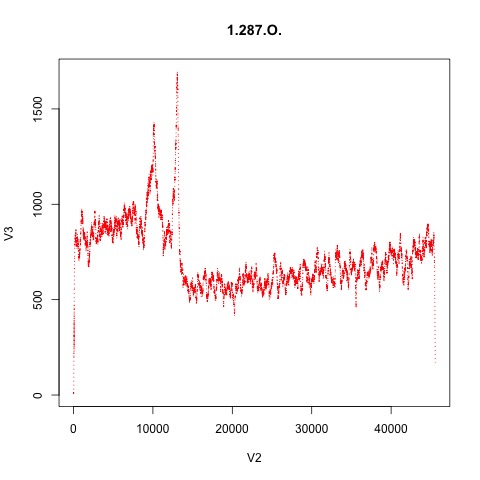

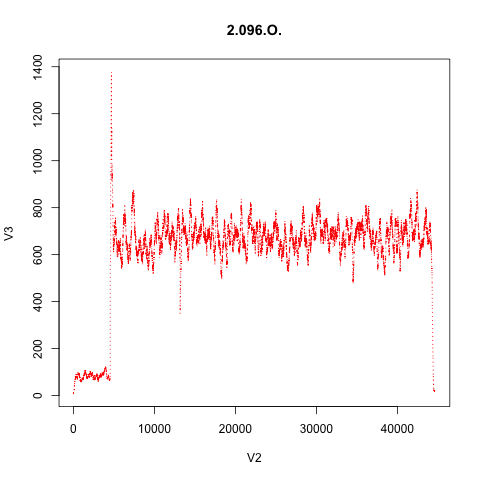

In [80]:
%%R -i grouplist
for (item in grouplist){
    filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
    print(item)
    if(file.info(filename)$size>0) {
    if (cov_shift_test(item, filename)){
        print(paste(item, "has a coverage shift", sep=" "))
        coverage<-read.table(filename, sep="\t")
        with(coverage, plot(V2, V3, main=item, type="l", col="red", lty=3))
    } else{
        print("no coverage shift")
    }
    }}

In [85]:
%%R

even_check<-function(item, filename, upper_sd_factor=5, pts_above_thresh=10){
        coverage<-read.table(filename, sep="\t")
        even_above_ave<-coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*upper_sd_factor),]
        
        if (nrow(even_above_ave)<pts_above_thresh)  {
            
            return(TRUE)
            
        } else {return(FALSE)}
        }

In [88]:
%%R
item="1.189.B."
filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")
even_check(item, filename)

[1] TRUE


[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "1.036.O. has even coverage"
[1] "1.048.O. has even coverage"
[1] "1.062.O. has even coverage"
[1] "no even coverage"
[1] "1.085.O. has even coverage"
[1] "no even coverage"
[1] "1.107.B. has even coverage"
[1] "1.116.O. has even coverage"
[1] "1.125.O. has even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "1.242.O. has even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"
[1] "no even coverage"


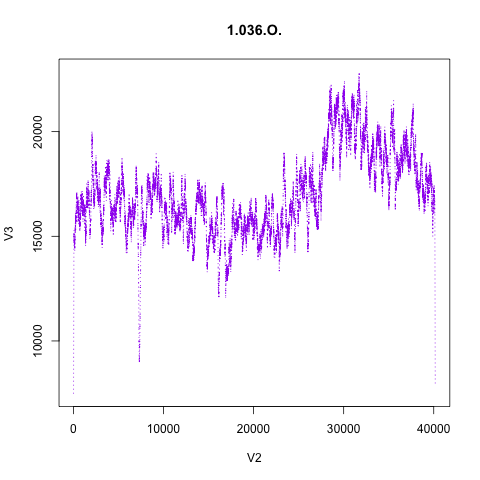

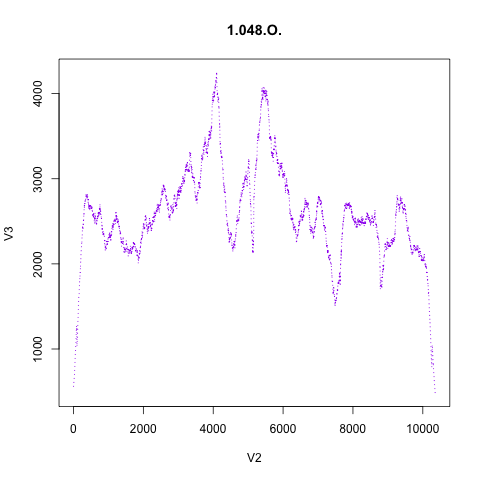

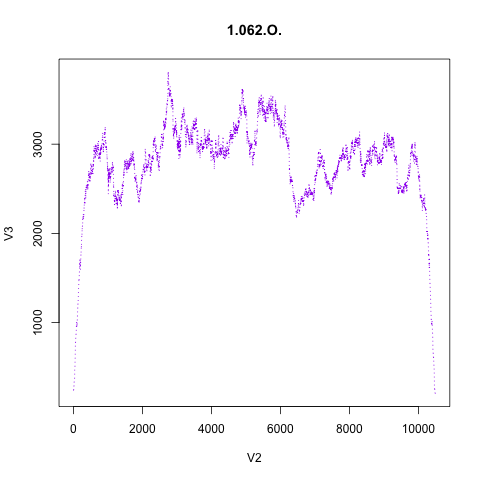

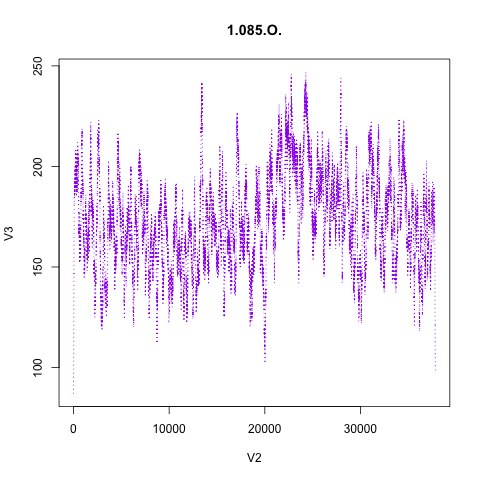

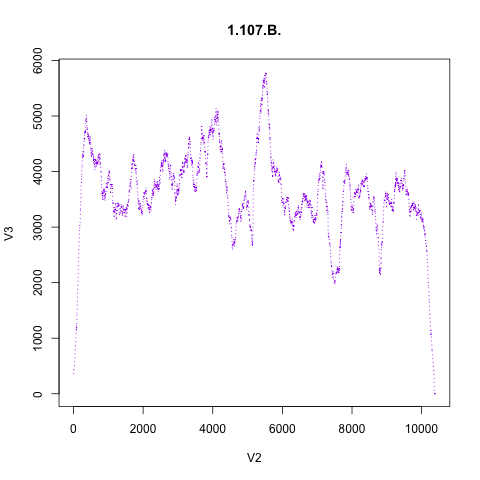

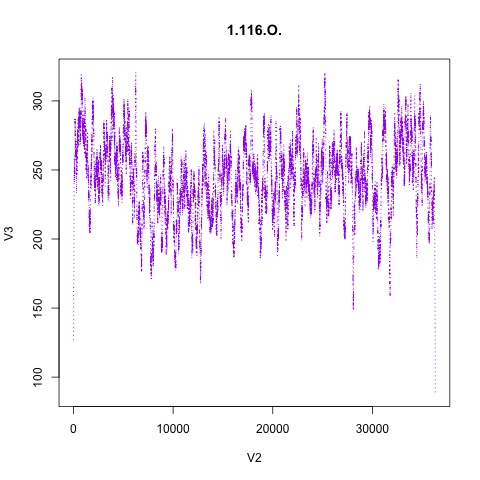

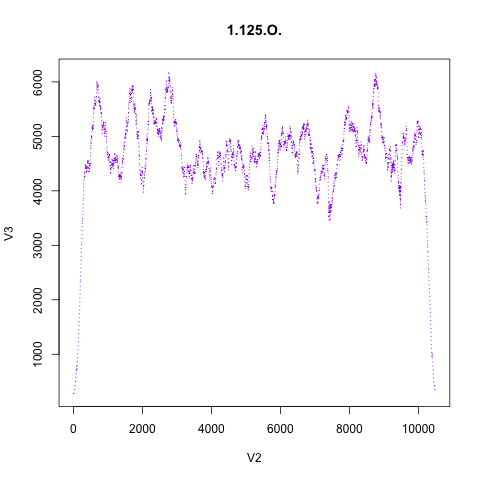

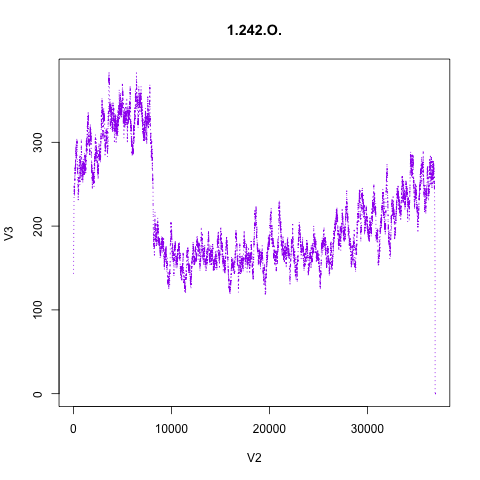

In [92]:
%%R -i grouplist
for (item in grouplist){
    filename=paste("../big_pipeline/",item,"step1.contig1.genomecoverage.txt", sep="")

    if(file.info(filename)$size>0) {
    if (even_check(item, filename, upper_sd_factor=3)){
        print(paste(item, "has even coverage", sep=" "))
        coverage<-read.table(filename, sep="\t")
        with(coverage, plot(V2, V3, main=item, type="l", col="purple", lty=3))
    } else{
        print("no even coverage")
    }
    }}

Error in if (cos_check(i, filename) == TRUE) { : 
  argument is of length zero


In [ ]:
%%R -i grouplist
###Cos-dip phages


next_step<-vector()

cos_pattern<-vector()
cos_count<-0

cos_sd_factor=4

for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
        coverage<-read.table(filename, sep="\t")

#Check for cos dip:
       
        length<-nrow(coverage)
        cos_omit_ends_cov<-coverage[(200:(length-200)),]   #excluding larger ends of the contig in this case      
        cos_below_ave<-cos_omit_ends_cov[cos_omit_ends_cov$V3<(mean(coverage$V3)-(sd(coverage$V3)*cos_sd_factor)),]
        minlocation<-0    
        if (nrow(cos_below_ave)>0){
            
            cos_below_ave$gaps<-c(diff(cos_below_ave$V2),1)
            cos_below_ave_peaks<-cos_below_ave[cos_below_ave$gaps<5,]
            size<-max(cos_below_ave_peaks$V2)-min(cos_below_ave_peaks$V2)
            if (size < 1000 & size>50){
            
             
                with(coverage, plot(V2, V3, type="n",xlab="position",ylab="coverage", main=paste(item, size, sep=" ")))
                with(coverage, lines(V2,V3))
                with(cos_below_ave, points(V2,V3, col="green",pch=19))
                cos_pattern<-c(cos_pattern,item)        #add significant minimum coverage phage contigs to list
                cos_count=cos_count+1

        } else {next_step<-c(next_step, item)}
        } else {next_step<-c(next_step,item)}
            }}

after_cos<-next_step

#mu-like phages

grouplist<-next_step
next_step<-vector()

mu<-vector()
mu_count<-0

mu_factor=5

for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
         coverage<-read.table(filename, sep="\t")
         length=nrow(coverage)
         peaks<-coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*mu_factor),]
         mu_size<-max(peaks$V2)-min(peaks$V2) 
                #max_peaks<-max(peaks$V2)
                #min_peaks<-min(peaks$V2)
                #mu_size<-max_peaks-min_peaks
                
                
               if (((min(peaks$V2)<500&max(peaks$V2)<500)|(min(peaks$V2)>(length-500)&max(peaks$V2)>length-500)) & mu_size<300 & (coverage$V2[coverage$V3==min(coverage$V3)]<500|coverage$V2[coverage$V3==min(coverage$V3)]>(length-500))){
                           mu_count<-mu_count+1
                           mu<-c(mu, item)
                            with(coverage, plot(V2, V3, type="l", lty=2, col="navy blue", main=paste(item, "Mu-like", sep="")))         
                            }
        else {next_step<-c(next_step, item)}
        }}
after_cos_mu<-next_step

#internal maxima
grouplist<-after_cos_mu
#grouplist<-next_step
next_step<-vector()

stretch=6
sd_factor=1

tr_candidate<-vector()
tr_start<-vector()
tr_stop<-vector()


#phages that have both an extremely high coverage peak and an extremely low coverage peak
hl<-vector()
hl_count<-0

#sip="small internal peak"
sip<-vector()
sip_start<-vector()
sip_stop<-vector()
sip_count<-0

count<-0

#create coverage plots for each genome
for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
    
    coverage<-read.table(filename, sep="\t")
    length<-nrow(coverage)
    coverage$V3_stretch<-coverage$V3^stretch
    
    coverage1<-coverage[(500:(length-500)),] 
    above_ave<-coverage1[coverage1$V3_stretch>(mean(coverage$V3_stretch)+sd(coverage$V3_stretch)*sd_factor),]
    if (nrow(above_ave)>0){
    above_ave$gaps<-c(diff(above_ave$V2),1)
    
    aamin<-min(above_ave$V2)
    aamax<-max(above_ave$V2)
    aa_region_mean<-mean(coverage[aamin:aamax,]$V3)
    all_mean<-mean(coverage$V3)
        
    size<-aamax-aamin

    #print(paste(item, paste(aamin, aamax, sep=" to "),"region coverage is", aa_region, "; total coverage is", all_mean,sep=" "))
    if(nrow(above_ave)>1 & (aa_region_mean>(all_mean+(sd(coverage$V3)*sd_factor))) & nrow(coverage)>15000){
        if (size<1000){
            above_ave$gaps<-c(diff(above_ave$V2),1)

            size<-max(above_ave$V2)-min(above_ave$V2)
            start<-min(above_ave$V2)
            stop<-max(above_ave$V2)

            length<-nrow(coverage)
            min_cov<-min(coverage$V3)
            mean_cov<-mean(coverage$V3)
            sd_cov<-sd(coverage$V3)

            #numbers needed for mu test:
            difference<-diff(coverage$V3)
            difference<-c(0,difference)
            cov1<-cbind(coverage, difference)
            length<-nrow(cov1)
            mid<-length/2
            cut_spot<-with(cov1[1:mid,], V2[which.max(difference)])
            if (cut_spot>300){cut_spot<-0}
            cut_spot2<-with(cov1[mid:length,], V2[which.min(difference)])
            if (cut_spot2<length-300){cut_spot2<-length}

            minlocation<-round(median(coverage$V2[coverage$V3==min_cov]))
            if ((minlocation>(length-1000)|minlocation<1000) & length>3000){
                    minlocation<-round(median(coverage$V2[coverage$V3[100:nrow(coverage)-100]==min(coverage$V3[100:nrow(coverage)-100])]))
                    minlocation<-round(median(coverage$V2[which.min(coverage$V3[1000:(length-1000)])]))+1000 #id location of minimum coverage that is not within 1000 bp of either terminus
                    min_cov=min(coverage$V3[1000:(length-1000)])
                }

            
                if (min_cov<mean_cov-sd_cov*2 & minlocation>(start-200) & minlocation<(start+200)) { 

                    sip<-c(sip, item)
                    with(coverage, plot(V2, V3, type="l", lty=2, col="forest green", main=paste(item, "high low", sep="")))
                    sip_count<-sip_count+1
                } 
                else {
                    sip<-c(sip, item)
                    sip_start<-c(sip_start, min(above_ave$V2))
                    sip_stop<-c(sip_stop, max(above_ave$V2))
                    with(coverage, plot(V2, V3, type="l", lty=2, col="orange", main=paste(item, "small internal coverage max", sep="")))

                    sip_count=sip_count+1
                }

            } else {

            
            tr_candidate<-c(tr_candidate, item)
            tr_start<-c(tr_start, min(above_ave$V2))
            tr_stop<-c(tr_stop, max(above_ave$V2))
            with(coverage, plot(V2, V3, type="l", lty=2, col="black", main=paste(item, "long terminal repeats", sep=" ")))
            with(coverage[aamin:aamax,], points(V2, V3, pch=19, cex=.5, col="green"))

            count=count+1

            } 
    }  else {next_step<-c(next_step, item)}
    }
    }
    }

after_cos_mu_tr<-next_step

#multiple peaks 

#grouplist<-after_cos_mu_tr
grouplist<-next_step
next_step<-vector()

stretch=5
mp_sd_factor=5

mp<-vector() #mp stands for multiple peaks
mp_count<-0


for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
        coverage<-read.table(filename, sep="\t")
        length<-nrow(coverage)


        #with(above_ave, plot(V2, gaps, col="maroon", pch=19, xlim=c(0, max(coverage$V2)), main=paste(item, size,max(gaps), sep=":")))
        coverage$V3_stretch<-coverage$V3^stretch        

        mp_omit_ends_cov<-coverage[(200:(length-200)),]   #excluding larger ends of the contig in this case
        mp_above_ave<-mp_omit_ends_cov[mp_omit_ends_cov$V3>(mean(coverage$V3)+sd(coverage$V3)*mp_sd_factor),]
    if (nrow(mp_above_ave)>0){
        
        mp_above_ave$gaps<-c(diff(mp_above_ave$V2),1)
        mp_above_ave_peaks<-mp_above_ave[mp_above_ave$gaps>2000,] 
        
        if (nrow(mp_above_ave_peaks)>0){
                with(coverage, plot(V2, V3, type="l", lty=2, col="orange", main=paste(item, nrow(mp_above_ave_peaks), sep=" ")))
                with(mp_above_ave_peaks, points(V2, V3, col="green", pch=19))
                abline(mean(coverage$V3),0, col="purple")
                abline(mean(coverage$V3)+sd(coverage$V3)*sd_factor,0, col="red")
                #with(coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*sd_factor),], points(V2, V3, col="green", cex=.2, pch=19))
                mp<-c(mp, item)
                mp_count<-mp_count+1
   
        
        }else {next_step<-c(next_step, item)}}
    else {
            next_step<-c(next_step, item)}
    }
    }
after_cos_mu_tr_mp<-next_step

#headful phage test; iteration 1:

splits=c(1200,1300,1400,1500,1600,1800,2000)
mean_threshold=6

#grouplist<-next_step
grouplist<-after_cos_mu_tr_mp
next_step<-vector()

#splits=c(1400)
splitspots=vector()
coverage_shift=vector()
everything_else=vector()


headful=vector()
headful_count=0

for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
    coverage<-read.table(filename, sep="\t")
    if(nrow(coverage)>max(splits)){
    #midpoint=0
    length<-nrow(coverage)
    
    for (s in splits){
        
        coverage$bins<-as.numeric(cut(coverage$V2, round(length/s)))
        bin_sum<-group_by(coverage, bins)%>%summarise(mean=mean(V3), stdev=sd(V3)) 
        bin_sum$dif<-c(abs(diff(bin_sum$mean)),0)
        threshold<-mean(bin_sum$dif)*mean_threshold
        if ((max(bin_sum$dif)>threshold) & (nrow(bin_sum[bin_sum$dif>threshold,])==1)){

            with(coverage, plot(V2,V3,main=paste(item, "binsize used was" ,s, sep=" "), type="n", ylab="Coverage", xlab="Genome"))
            with(coverage, lines(V2,V3, lty=2, col="black"))
            with(bin_sum, points(bins*s, mean, pch=19, col="forest green"))
            #with(bin_sum, points((bins[bin_sum$dif==max(bin_sum$dif)])*binsize, mean[bin_sum$dif==max(bin_sum$dif)], col="red", pch=19, cex=1.5))
            with(bin_sum, points((bins[bin_sum$dif==max(bin_sum$dif)])*s, mean[bin_sum$dif==max(bin_sum$dif)], col="purple", pch=8, cex=2))

            headful<-c(headful, item)
            headful_count<-headful_count+1
            
            #with(bin_sum, plot(bins*s, dif, main=paste(phage, 'binned by', s, "bp", sep=" "), xlab="genome",ylab="difference in mean coverage"))
            #with(bin_sum, points((bins[bin_sum$dif==max(bin_sum$dif)])*binsize, dif[bin_sum$dif==max(bin_sum$dif)], col="red", pch=19))     
            #with(bin_sum, points(bins[bin_sum$dif>threshold]*binsize, dif[bin_sum$dif>threshold], col="red", pch=8, cex=2))

            break
        } 
    }
    if (item %in% headful==FALSE){
        #with(coverage, plot(V2, V3, lty=2, col="dark grey", main=paste(phage,"no pattern yet identified", sep=" ")))
        next_step<-c(next_step, item)
    }
    
    }
    } 
    }

after_cos_mu_tr_mp_hf1<-next_step

#evenness check~round 1
grouplist<-next_step
#grouplist<-after_cos_mu_tr_mp_hf1
next_step<-vector()     

even<-vector()
even_count<-0

upper_sd_factor<-3

for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
        coverage<-read.table(filename, sep="\t")
        even_above_ave<-coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*upper_sd_factor),]
        
        if (nrow(even_above_ave)<10)  {
            with(coverage, plot(V2, V3, main=paste(item, "even coverage", sep=" "), type='l', col="slateblue3"))
            even<-c(even, item)
            even_count<-even_count+1

        } else {next_step<-c(next_step, item)}
        }
    }
after_cos_mu_tr_mp_hf1_even<-next_step

#headful phage test; iteration 2:


splits=c(800,1000,1200,1300,1400,1500,1600,1800,2000)
mean_threshold=5


#grouplist<-next_step
grouplist<-after_cos_mu_tr_mp_hf1_even
next_step<-vector()

#splits=c(1400)
splitspots=vector()
coverage_shift=vector()
everything_else=vector()
mean_threshold=4

for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
    coverage<-read.table(filename, sep="\t")
    if(nrow(coverage)>max(splits)){
    #midpoint=0
    length<-nrow(coverage)
    
    for (s in splits){
        
        coverage$bins<-as.numeric(cut(coverage$V2, round(length/s)))
        bin_sum<-group_by(coverage, bins)%>%summarise(mean=mean(V3), stdev=sd(V3)) 
        bin_sum$dif<-c(abs(diff(bin_sum$mean)),0)
        threshold<-mean(bin_sum$dif)*mean_threshold
        if ((max(bin_sum$dif)>threshold) & (nrow(bin_sum[bin_sum$dif>threshold,])==1)){

            with(coverage, plot(V2,V3,main=paste(item, "binsize used was" ,s, sep=" "), type="n", ylab="Coverage", xlab="Genome"))
            with(coverage, lines(V2,V3, lty=2, col="black"))
            with(bin_sum, points(bins*s, mean, pch=19, col="forest green"))
            #with(bin_sum, points((bins[bin_sum$dif==max(bin_sum$dif)])*binsize, mean[bin_sum$dif==max(bin_sum$dif)], col="red", pch=19, cex=1.5))
            with(bin_sum, points((bins[bin_sum$dif==max(bin_sum$dif)])*s, mean[bin_sum$dif==max(bin_sum$dif)], col="purple", pch=8, cex=2))

            headful<-c(headful, item)
            headful_count<-headful_count+1
            
            #with(bin_sum, plot(bins*s, dif, main=paste(phage, 'binned by', s, "bp", sep=" "), xlab="genome",ylab="difference in mean coverage"))
            #with(bin_sum, points((bins[bin_sum$dif==max(bin_sum$dif)])*binsize, dif[bin_sum$dif==max(bin_sum$dif)], col="red", pch=19))     
            #with(bin_sum, points(bins[bin_sum$dif>threshold]*binsize, dif[bin_sum$dif>threshold], col="red", pch=8, cex=2))

            break
        } 
    }
    if (item %in% headful==FALSE){
        #with(coverage, plot(V2, V3, lty=2, col="dark grey", main=paste(phage,"no pattern yet identified", sep=" ")))
        next_step<-c(next_step, item)
    }
    
    }
    } 
    }

after_cos_mu_tr_mp_hf1_even_hf2<-next_step


#evenness check round 2

grouplist<-next_step
#grouplist<-after_cos_mu_tr_mp_hf1_even_hf2
next_step<-vector()     

upper_sd_factor<-5

for (item in grouplist){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
        coverage<-read.table(filename, sep="\t")
        even_above_ave<-coverage[coverage$V3>(mean(coverage$V3)+sd(coverage$V3)*upper_sd_factor),]
        
        if (nrow(even_above_ave)<10)  {
            with(coverage, plot(V2, V3, main=paste(item, "even coverage", sep=" "), type='l', col="slateblue3"))
            even<-c(even, item)
            even_count<-even_count+1

        } else {next_step<-c(next_step, item)}
        }
    }
after_cos_mu_tr_mp_hf1_even_hf2_even2<-next_step


#the rest
npd<-vector()   #npd stands for "no pattern determined"
npd_count<-0


for (item in next_step){
    filename<-paste(item,"step1.contig1.genomecoverage.txt",sep="")
    if(file.info(filename)$size>0) {
        coverage<-read.table(filename, sep="\t")
        with(coverage, plot(V2, V3, type="l", col="dark gray", lty=2))
        npd<-c(npd, item)
        npd_count<-npd_count+1
        }}


print(paste("there are", mu_count, "mu-like phages;",cos_count, "cos-like phages;", sip_count, "small internal peak phages;",sep=" "))
print(paste("there are", count, "long terminal repeat phages;", mp_count,"phages with multiple peaks;",headful_count,"headful phages;", sep=" "))
print(paste("and", even_count, "phages with even genome coverage; and",npd_count,"phages with no determined pattern",sep=" "))